# Recommender Systems with Graph Neural Networks in PyG

In this notebook was used materials from the tutorial By Derrick Li, Peter Maldonado, Akram Sbaih as part of the Stanford CS224W course project.

## Setup

First, we'll install the necessary packages.

In [795]:
# %%capture
# # Environment Setup (note that capture silences the console output)
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !git clone https://github.com/pmaldonado/cs224w-project-data.git

Next, let's import all of the modules that we'll use in this notebook.

In [990]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

Lastly, we should double check that our environment is working as expected.

In [991]:
torch_geometric.__version__

'2.4.0'

In [992]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset and Preprocessing


In [993]:
u_data_columns = ['user id', 'item id', 'rating', 'timestamp']
u_data = pd.read_csv("ml-100k/u.data", sep="\t", names=u_data_columns)
u_data.head()
print(len(u_data))
display(u_data.head(5))

100000


,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [994]:
u1_train = pd.read_csv("ml-100k/u1.base", sep="\t", names=u_data_columns)
u2_train = pd.read_csv("ml-100k/u2.base", sep="\t", names=u_data_columns)
u3_train = pd.read_csv("ml-100k/u3.base", sep="\t", names=u_data_columns)
u4_train = pd.read_csv("ml-100k/u4.base", sep="\t", names=u_data_columns)
u5_train = pd.read_csv("ml-100k/u5.base", sep="\t", names=u_data_columns)

In [995]:
u1_test = pd.read_csv("ml-100k/u1.test", sep="\t", names=u_data_columns)
u2_test = pd.read_csv("ml-100k/u2.test", sep="\t", names=u_data_columns)
u3_test = pd.read_csv("ml-100k/u3.test", sep="\t", names=u_data_columns)
u4_test = pd.read_csv("ml-100k/u4.test", sep="\t", names=u_data_columns)
u5_test = pd.read_csv("ml-100k/u5.test", sep="\t", names=u_data_columns)
u5_test.head(3)

,user id,item id,rating,timestamp
0,1,3,4,878542960
1,1,13,5,875071805
2,1,15,5,875071608


In [996]:
train_fold = [u1_train, u2_train, u3_train, u4_train, u5_train]
test_fold = [u1_test, u2_test, u3_test, u4_test, u5_test]

In [1000]:
N_U = u_data['user id'].nunique()
N_I = u_data['item id'].nunique()
print("Number of Unique Users : ", N_U)
print("Number of unique Items : ", N_I)

Number of Unique Users :  943
Number of unique Items :  1682


In [ ]:
u_user_columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
u_user = pd.read_csv("ml-100k/u.user", sep="|", names=u_user_columns, encoding='latin-1')
u_user.head(3)

In [1002]:
def idx_columns(data):
    le_user = pp.LabelEncoder()
    le_item = pp.LabelEncoder()
    data['user_id_idx'] = le_user.fit_transform(data['user id'].values)
    data['item_id_idx'] = le_item.fit_transform(data['item id'].values)
    return data

In [1003]:
for i, data in enumerate(train_fold):
    train_fold[i] = idx_columns(data)

In [1004]:
train_fold[0]

,user id,item id,rating,timestamp,user_id_idx,item_id_idx
0,1,1,5,874965758,0,0
1,1,2,3,876893171,0,1
2,1,3,4,878542960,0,2
3,1,4,3,876893119,0,3
4,1,5,3,889751712,0,4
...,...,...,...,...,...,...
79995,943,1067,2,875501756,942,1060
79996,943,1074,4,888640250,942,1067
79997,943,1188,3,888640250,942,1180
79998,943,1228,3,888640275,942,1220


In [1005]:
u_data = idx_columns(u_data)

In [1006]:
for i, data in enumerate(test_fold):
    test_fold[i] = idx_columns(data)

### Minibatch Sampling

Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [1007]:
def data_loader(data, batch_size, n_usr=N_U, n_itm=N_I):
    

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    users = interected_items_df['user_id_idx'].sample(batch_size).values
    
    users.sort()
    
    pos_items = [random.choice(x) for x  in interected_items_df.query("`user_id_idx` in @users")['item_id_idx']]
    neg_items = [sample_neg(x) for x  in interected_items_df.query("`user_id_idx` in @users")['item_id_idx']]
    
    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_fold[0], 16)

(tensor([ 43, 104, 126, 217, 284, 318, 434, 507, 521, 524, 585, 611, 634, 748,
         878, 906]),
 tensor([1369, 1206, 1690,  950, 1127, 1211,  997, 1161, 1075, 1067, 1127, 1814,
         1811, 1443,  957, 1179]),
 tensor([1697, 1430, 1650, 1064, 1746, 1614, 1054, 2264, 1670, 1359, 1035, 1979,
         1087, 1689, 2515, 1054]))

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [1009]:
def create_edgeAttr(data):
    u_t = torch.LongTensor(data['user_id_idx'])
    i_t = torch.LongTensor(data['user_id_idx']) + N_U
    rat = torch.LongTensor(data['rating'])

    edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
    )).to(device)

    edge_weight = torch.cat((rat, rat)).to(device)
    
    return edge_index, edge_weight

In [1010]:
main_edge_index, main_edge_weight = create_edgeAttr(u_data)
print(main_edge_index.shape, main_edge_weight.shape)

torch.Size([2, 200000]) torch.Size([200000])


## Model Architecture

### NGCF Layer

NGCF is architecture that originated by researchers who applied [Graph Convolutional Networks (GCNs)]() to recommender systems.

One layer of NGCF updates user and item embeddings as follows:

$$e_{u}^{(k+1)} = \sigma\left(W_1 e_u^{(k)} + \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}(W_1e^{(k)}_i + W_2(e^{(k)}_i \odot e^{(k)}_u))\right)$$

$$e_{i}^{(k+1)} = \sigma\left(W_1 e_i^{(k)} + \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}(W_1e^{(k)}_u + W_2(e^{(k)}_u \odot e^{(k)}_i))\right)$$

Typically, NGCF is implemented with dropout before the activation and with an activation function $\sigma$ of LeakyReLU.

In [1013]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index, edge_weight):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]
    norm = norm * edge_weight

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

### Recommender System GNN

For this tutorial, we will be using the following class, `RecSysGNN` in order to stack the NGCF or LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are `n`-hops away in a model that uses `n` layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's `n`-hop neighborhood, so they need to be propagated as well.

In [1014]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    self.convs = nn.ModuleList(
      NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
    )

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.embedding.weight, gain=1)


  def forward(self, edge_index, edge_weight):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index, edge_weight=edge_weight)
      embs.append(emb)

    out = (torch.cat(embs, dim=-1))

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index, edge_weight):
    emb0, out = self(edge_index, edge_weight)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

## Loss function and metrics

here is implemented both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [1015]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [1016]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
      torch.LongTensor(train_data['user_id_idx'].values),
      torch.LongTensor(train_data['item_id_idx'].values)
    ))
    v = torch.ones((len(train_data)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
        .to_dense().to(device)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item
    # interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df['item_id_idx'], metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate model

Now that we've implemented NGCF in PyG, we can train and evaluate its performance!

In [1017]:
latent_dim = 64
n_layers = 3

EPOCHS = 3
BATCH_SIZE = 224
DECAY = 0.0001
LR = 0.005
K = 20

In [1019]:
def train_one_fold(model, train, optimizer, epoch):
    n_batch = int(len(train)/BATCH_SIZE)

    final_loss_list = []
    bpr_loss_list = []
    reg_loss_list = []

    model.train()
    for batch_idx in tqdm(range(n_batch), total=n_batch, desc=f"Train Epoch: {epoch}/{EPOCHS}"):
        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE)
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, main_edge_index, main_edge_weight)

        bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
        )
        reg_loss = DECAY * reg_loss
        final_loss = bpr_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        bpr_loss_list.append(bpr_loss.item())
        reg_loss_list.append(reg_loss.item())
    
    return final_loss_list, bpr_loss_list, reg_loss_list

In [1024]:
from tqdm import tqdm

def train_and_eval(model, optimizer, train):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  i = 0
  while True:
      if i > EPOCHS:
          break
      
      train_fs = train[:i%5] +train[i%5+1:] 
      val_f = train[i%5]

      for train_f in train_fs:
          final_loss_list, bpr_loss_list, reg_loss_list = train_one_fold(model, train_f, optimizer, i)

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      model.eval()
      with torch.no_grad():
          tqdm(range(1), total=1, desc=f"Val Epoch: {i}/{EPOCHS}")
          _, out = model(main_edge_index, main_edge_weight)
          final_user_Embed, final_item_Embed = torch.split(out, (N_U, N_I))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, N_U, N_I, train_fs[i], val_f, K
          )

          recall_list.append(round(test_topK_recall,4))
          precision_list.append(round(test_topK_precision,4))

      i += 1

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

### Train and eval NGCF

In [1025]:
ngcf = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=N_U,
  num_items=N_I,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([2625, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [1026]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_fold)

Train Epoch: 0/3:   0%|          | 0/357 [00:00<?, ?it/s]

Val Epoch: 3/3:   0%|          | 0/1 [00:00<?, ?it/s]


In [1029]:
epoch_list = [(i+1) for i in range(EPOCHS+1)]

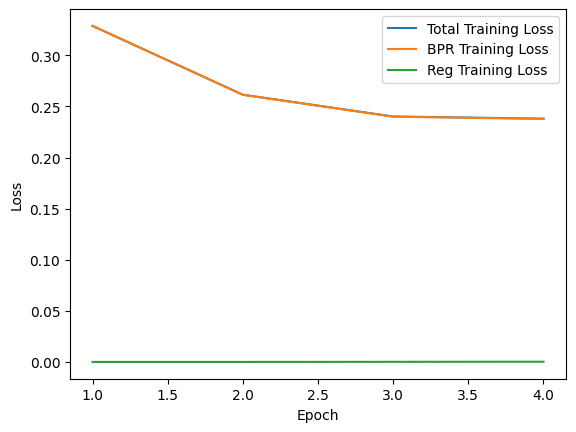

In [1030]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

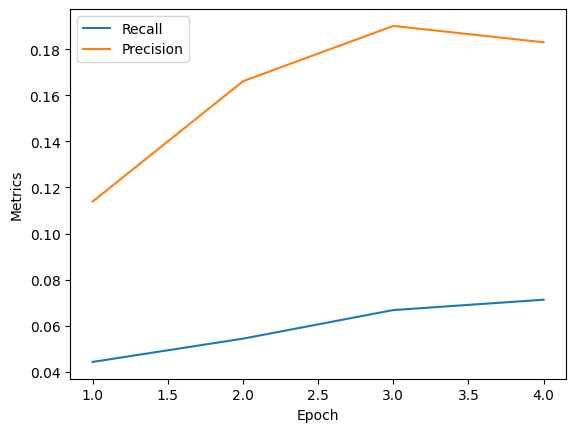

In [1031]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [1032]:
torch.save(ngcf.state_dict(), 'ngcf_vf.pt')

## Paper References

1. Harper, F. Maxwell, and Konstan, Joseph A. “The MovieLensDatasets: History and Context.” ACM Transactions on Interactive Intelligence Systems (TiiS) 5, 4. 2015.
2. He, Xiangnan, et al. “LightGCN: Simplifying and powering graph convolution network for recommendation.” Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2020.
3. Wang, Xiang, et al. “Neural graph collaborative filtering.” Proceedings of the 42nd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2019.

## Code References

We thank the authors of the following codebases and notebooks, from which parts of this tutorial were inspired or adapted.

- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

- https://github.com/gusye1234/LightGCN-PyTorch

- https://github.com/SytzeAndr/NGCF_RP32/blob/hand-in/NGCF.ipynb
